In [1]:
from datasets import load_dataset
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

dataset = {}
for split in ["train", "validation", "test"]:
    dataset[split] = load_dataset("ILSVRC/imagenet-1k", trust_remote_code=True, split=split)


transforms_list = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)


def transforms(examples):
    examples["pixel_values"] = [transforms_list(image.convert("RGB")) for image in examples["image"]]
    return examples


dataset["train"].set_transform(transforms)
dataset["validation"].set_transform(transforms)
dataset["test"].set_transform(transforms)

from torch.utils.data import Dataset, DataLoader


class HFDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()

        self.dataset = dataset

    def __getitem__(self, index):
        data = self.dataset[index]
        return data["pixel_values"], data["label"]

    def __len__(self):
        return len(self.dataset)


train_dataset = HFDataset(dataset["train"])
validation_dataset = HFDataset(dataset["validation"])

/home/davor/miniconda3/envs/ramp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import timm

model = timm.create_model("vgg16")
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
import torch
from torch import nn
from types import MethodType
from copy import deepcopy
from ramp_gae.utils import normalize_abs_sum_to_one


class LRPRule:
    def __init__(self):
        self.module_to_rule_dict = {}
        self.default_rule = None

    def rule_for_layer(self, module: nn.Module):
        raise NotImplemented("module_to_rule_dict must be implemented")


class AbsLRPRule(LRPRule):
    def __init__(self):
        self.module_to_rule_dict = {nn.MaxPool2d: divide_abslrp_rule, nn.Dropout: identity_rule, nn.ReLU: identity_rule}
        self.default_rule = abslrp_rule

    def rule_for_layer(self, module: nn.Module):
        for module_class, rule in self.module_to_rule_dict.items():
            if isinstance(module, module_class):
                return rule
        return self.default_rule


def identity_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    return output_relevance


def abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    input = self.saved_tensors["input"][0]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    output_relevance = output_relevance * output.sign() / (output + 1e-9)
    # apply abslrp rule
    relevance = torch.autograd.grad(output, input, output_relevance)[0] * input

    print(self.__class__, relevance[0].sum(), relevance[0].shape, output_relevance[0].sum(), output_relevance[0].shape)
    # delete saved tensors
    self.saved_tensors = {}
    return relevance.detach()


def divide_abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    input = self.saved_tensors["input"][0]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    # apply abslrp rule
    relevance = torch.autograd.grad(output, input, output_relevance)[0] * input

    print(relevance[0].sum(), relevance[0].shape, output_relevance[0].sum(), output_relevance[0].shape)
    # delete saved tensors
    self.saved_tensors = {}
    return relevance.detach()


"""def abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    x = self.saved_tensors["input"][0]
    h = self.saved_tensors["output"]
    prel = output_relevance

    if "abs_output" in self.saved_tensors:
        h = h + self.saved_tensors["abs_output"]

    h_sign = torch.where(h >= 0, 1, -1)
    h_eta = torch.where(h == 0, 1e-9, 0)

    prel_scale = prel * h_sign / (h + h_eta)

    rel_pos = torch.autograd.grad(h, x, prel_scale.clamp(min=0), retain_graph=True)[0] * x
    rel_neg = torch.autograd.grad(h, x, prel_scale.clamp(max=0), retain_graph=False)[0] * x

    prel_pos = prel.flatten(1).clamp(min=0).sum(-1)
    prel_neg = prel.flatten(1).clamp(max=0).sum(-1)
    num_dims = len(rel_pos.shape[1:])
    for _ in range(num_dims):
        prel_pos = prel_pos.unsqueeze(-1)
        prel_neg = prel_neg.unsqueeze(-1)

    rel = prel_pos * normalize_abs_sum_to_one(rel_pos) + prel_neg.abs() * normalize_abs_sum_to_one(rel_neg)

    print(rel[0].sum(), rel[0].shape, output_relevance[0].sum(), output_relevance[0].shape)
    self.saved_tensors = {}
    return rel


def divide_abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    x = self.saved_tensors["input"][0]
    h = self.saved_tensors["output"]
    prel = output_relevance

    if "abs_output" in self.saved_tensors:
        h = h + self.saved_tensors["abs_output"]

    h_sign = torch.where(h >= 0, 1, -1)
    h_eta = torch.where(h == 0, 1e-9, 0)

    prel_scale = prel

    rel_pos = torch.autograd.grad(h, x, prel_scale.clamp(min=0), retain_graph=True)[0] * x
    rel_neg = torch.autograd.grad(h, x, prel_scale.clamp(max=0), retain_graph=False)[0] * x

    prel_pos = prel.flatten(1).clamp(min=0).sum(-1)
    prel_neg = prel.flatten(1).clamp(max=0).sum(-1)
    num_dims = len(rel_pos.shape[1:])
    for _ in range(num_dims):
        prel_pos = prel_pos.unsqueeze(-1)
        prel_neg = prel_neg.unsqueeze(-1)

    rel = prel_pos * normalize_abs_sum_to_one(rel_pos) + prel_neg.abs() * normalize_abs_sum_to_one(rel_neg)

    print(rel[0].sum(), rel[0].shape, output_relevance[0].sum(), output_relevance[0].shape)
    self.saved_tensors = {}
    return rel"""


def composite_abslrp_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    for child in list(self.children())[::-1]:
        print("before", output_relevance[0].sum())
        output_relevance = child.explain(output_relevance)
        print("after", output_relevance[0].sum())
    return output_relevance


def abslrp_forward_hook(module: nn.Module, args: tuple, output: tuple) -> None:
    module.saved_tensors = {}
    # if module has learnable parameters, create a temporary copy of the module and infer over absolute parameters
    if getattr(module, "weight", None) is not None:
        abs_module = deepcopy(module)
        # remove this hook from copied model
        if getattr(abs_module, "_forward_hooks", None):
            for i, hook in abs_module._forward_hooks.items():
                if hook.__name__ == "abslrp_forward_hook":
                    break
            del abs_module._forward_hooks[i]

        abs_module.weight.data = abs_module.weight.data.abs()
        if getattr(module, "bias", None) is not None:
            abs_module.bias.data = abs_module.bias.data.abs()
        abs_output = abs_module(*args)
        # save the outputs and inputs
        module.saved_tensors["abs_output"] = abs_output
    module.saved_tensors["output"] = output
    module.saved_tensors["input"] = args


def apply_rule(module: nn.Module, rule: LRPRule) -> list[nn.Module]:
    children_list = list(module.children())
    if not children_list:
        explain_func = rule.rule_for_layer(module)
        module.explain = MethodType(explain_func, module)
        module.register_forward_hook(abslrp_forward_hook)
        return

    module.explain = MethodType(composite_abslrp_rule, module)
    for child_module in children_list:
        apply_rule(child_module, rule=rule)

    return

In [4]:
apply_rule(model, AbsLRPRule())

In [5]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
for x, y in validation_loader:
    break

x.requires_grad = True
output = model(x)
relevance = model.explain(F.one_hot(output.max(-1)[1], num_classes=output.shape[-1]))

before tensor(1)
before tensor(1)
<class 'torch.nn.modules.linear.Identity'> tensor(1., grad_fn=<SumBackward0>) torch.Size([1000]) tensor(8.4376, grad_fn=<SumBackward0>) torch.Size([1000])
after tensor(1.)
before tensor(1.)
<class 'torch.nn.modules.linear.Linear'> tensor(1.0000, grad_fn=<SumBackward0>) torch.Size([4096]) tensor(0.9134, grad_fn=<SumBackward0>) torch.Size([1000])
after tensor(1.0000)
before tensor(1.0000)
after tensor(1.0000)
before tensor(1.0000)
before tensor(1.0000)
<class 'torch.nn.modules.flatten.Flatten'> tensor(1.0000, grad_fn=<SumBackward0>) torch.Size([4096, 1, 1]) tensor(15.4678, grad_fn=<SumBackward0>) torch.Size([4096])
after tensor(1.0000)
before tensor(1.0000)
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'> tensor(1.0000, grad_fn=<SumBackward0>) torch.Size([4096, 1, 1]) tensor(15.4678, grad_fn=<SumBackward0>) torch.Size([4096, 1, 1])
after tensor(1.0000)
after tensor(1.0000)
after tensor(1.0000)
before tensor(1.0000)
before tensor(1.0000)
after tensor(

In [6]:
relevance[0].sum()

tensor(-0.0044)

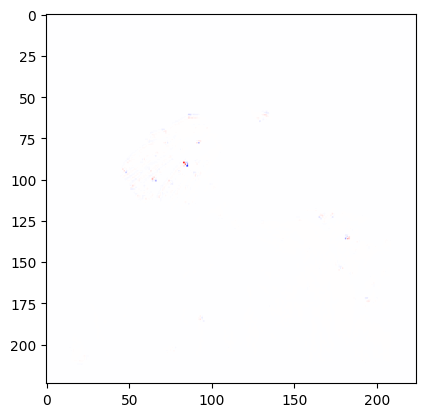

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 0
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="bwr")
plt.show()

In [8]:
model.features[0].saved_tensors

{}

In [9]:
model.ramp()

AttributeError: 'VGG' object has no attribute 'ramp'